# Assignment 1

### we have to build a decision tree from scratch using various calclulations


## Part 5 (10 points)
Plot a graph of training and validation error with respect to
depth of your decision tree. Also plot the training and validation error with respect
to number of nodes in the decision tree.

#### Imporitng Libraries

In [24]:
import pandas as pd
import numpy
import random
import math
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
eps = numpy.finfo(float).eps
from copy import deepcopy
import matplotlib.pyplot as plt
maxdepth = 0

#### Reading data from CSV and it's analysis

In [2]:
data = pd.read_csv('input_data/train.csv')
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.10,0.90,7,286,4,0,1,0,sales,low
1,0.89,0.93,4,249,3,0,0,0,sales,low
2,0.38,0.50,2,132,3,0,1,0,accounting,low
3,0.95,0.71,4,151,4,0,0,0,sales,medium
4,0.84,0.84,5,163,3,0,0,0,technical,low


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11238 entries, 0 to 11237
Data columns (total 10 columns):
satisfaction_level       11238 non-null float64
last_evaluation          11238 non-null float64
number_project           11238 non-null int64
average_montly_hours     11238 non-null int64
time_spend_company       11238 non-null int64
Work_accident            11238 non-null int64
left                     11238 non-null int64
promotion_last_5years    11238 non-null int64
sales                    11238 non-null object
salary                   11238 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 878.0+ KB


#### So, there is no missing values in the dataset and hence no preprocessing of filling missing values is to be done

In [4]:
data.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

### Checking the count of both the outcomes
- As the probelm is of binary classification , we first checked the skewness of the data towards an outcome.
- We can see that the zeroes count is much more than the ones count hence the tree will be biased

In [5]:
data.groupby('left').count()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary
left,,,,,,,,,
0,8563,8563,8563,8563,8563,8563,8563,8563,8563
1,2675,2675,2675,2675,2675,2675,2675,2675,2675


### Shuffling and spliting the data
- As mentioned in the assignment, we will first shuffle the data and then split it into two splits
- 80% Training Set
- 20% Testing Set

In [6]:
# train_data = data.sample(frac = 0.8, random_state = 200)
# test_data = data.drop(train_data.index)
train_data, test_data = numpy.split(data, [int(0.8 * len(data))])
attr = list(data)

In [7]:
def iscontinous(data,attr):
    if attr == 'left':
        return True
    if attr in list(data._get_numeric_data()):
        if len(data[attr].unique()) <= 2 :
            return False
        return True
    return False

In [8]:
categorical = [ x for x in attr if iscontinous(data,x) == False]
continous = [x for x in attr if iscontinous(data,x) == True]
print(categorical)
print(continous)

['Work_accident', 'promotion_last_5years', 'sales', 'salary']
['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'left']


#### This function will return unique values of a particular column given as parameter

In [9]:
def get_unique_values(data,col):
    return list(data[col].unique())

In [10]:
get_unique_values(data,'salary')

['low', 'medium', 'high']

 #### This function will list the column headers for any dataframe.

In [11]:
def get_attributes(data):
    return list(data)

## Entropy :
>- Entropy is the term of imputiry of the system, that is how much variation is present in the outcome.
>- The following function will take a dataframe and output label as an input and will calculate the entropy on the basis of frequency of output labels.


In [12]:
def entropy(data, labelcol):

    dic = dict(data[labelcol].value_counts())
    entropy = 0.0
    for label in dic.keys():
        entropy = entropy + (-(((1.0)*dic[label])/(len(data) + eps) * numpy.log2(((1.0)*dic[label])/(len(data) + eps )) ) ) 
        #print(entropy)
    return entropy
    

In [13]:
entropy(data,'left')

0.79175167848580907

## Information Gain
>- information gain is reduction in the entropy if we use a feature ( attribute ) as an decision boundary.
>- It calculates wieghted entropy for the unique values of the attribute and then subtracts it from the current entropy of the system.

In [14]:
def infogain(data, attr,labelcol):
    uniq = get_unique_values(data,attr)
    wt_entropy = 0.0
    for vals in uniq:
        selected_data = data.loc[data[attr] == vals]
        wieght = (1.0*len(selected_data))/(len(data) + eps )
        wt_entropy += wieght*entropy(selected_data,labelcol)
        #print(wt_entropy)
    return entropy(data, labelcol) - wt_entropy

## Information gain for numerical attribute:
> We sort the unique values and sort them and now considetring all points as an splitting point and selecting a point which gives maximum gain the storing the numerical split in the node and then spliting the data for >= spliting point and < spliting point

In [15]:
def infogainfornumerical(data,attr,labelcol):
   
    #df.sort_values(attr)
    #print(df)
    lista = list(data[attr].unique())
    listb = sorted(lista)
    midpoints = []
    for x in range(1,len(listb)):
        midpoints.append((listb[x-1] + listb[x])/2.0)
        
    maxgain = 0.0
    splitingpoint = -1
    dictof = {} 
    for x in midpoints:
        #print(x)
        data2 = data[data[attr] > x]
        data3 = data[data[attr] <= x]
        leftentropy = ((1.0*len(data2)) / len(data))*entropy(data2,labelcol)
        rightentropy = ((1.0*len(data3)) / len(data))*entropy(data3,labelcol)
        wt_entropy = leftentropy + rightentropy
        infogain = entropy(data, labelcol) - wt_entropy
        if infogain > maxgain:
            maxgain = infogain
            splitingpoint = x
    return maxgain,splitingpoint


In [16]:
infogain(data,'salary','left')

0.020887530533461041

In [17]:
def getcoldata(data,attr,value):
    return data.loc[data[attr] == value]

#### Maximum Gain
- Out of a list of attributes, we have to select that which attribute will be selected as a best decision boundary and for that we calculate inforamtion gain of eact feature and select the one whcih has max gain.

In [18]:
def max_gain(data, remaining_attrs , labelcol):
    maxgain = 0.0
    splitattr = ""
    splitingpointmain = -1
    global continous
    for attr in remaining_attrs:
        if attr in continous:
            gain,splitingpoint = infogainfornumerical(data,attr,labelcol)
        else:
            gain  = infogain(data,attr,labelcol)
            splitingpoint = -1
        #print (gain)
        if  gain >= maxgain:
            maxgain = gain
            splitattr = attr
            splitingpointmain = splitingpoint 
    if splitattr == "" :
        #print("NOT IN THIS")
        return 0,"Negative",-1
    return maxgain,splitattr,splitingpointmain

In [19]:
attr = list(data)
attr.remove('left')
max_gain(train_data,attr,'left')

(0.19436853577423674, 'satisfaction_level', 0.46499999999999997)

## Node of decision tree.
>- I have build id3 type structure of the tree that is each node will have n-ary children depending upon the number of unique values of the feature selected on that node.
>- Each node has a dictionary which will have key ( branch ) as its unique values and for each key there will be a node.
>- I have taken following attribute for the node
>>- attribute name selceted on that node
>>- decision on that node
>>- Dictionary of children
>>- depth
>>- positive count ( number of 1s )
>>- negative count ( numbers of 0s )


In [20]:
class node:
    attr = ""
    decision = -1
    children = {}
    depth = 0
    positive_count = 0
    negative_count = 0
    isnumeric = False
    splitingpoint  = -1
    numberofnodes = 0
    
    def __init__(self,attr,decision,children,depth,positive_count,negative_count,isnumeric, splitingpoint):
        self.attr = attr
        self.decision = decision
        self.children = children
        self.depth = depth
        self.positive_count = positive_count
        self.negative_count = negative_count
        self.isnumeric = isnumeric
        self.splitingpoint = splitingpoint
        node.numberofnodes += 1
        

## Building tree recursively
>- We first select the attribue with maximum gain , make it the root node and recurse the funciton for all its unique value.
>- We stop at two conditions 
>>1. If there are rows only of onr type of output
>>2. If all the attributes are used in the path.
>>> In that case we make decision on the probablity of outcome till that node.
>>3. If there are numerical attributes, we will binary split the data while finding the spliting point

In [21]:
def building_tree(data ,attrs , depth , stoping_depth):
    #print(attrs)

    posnegcount = dict(data['left'].value_counts())
    poscount = 0
    negcount = 0
    
    if 1 in posnegcount.keys():
        poscount = posnegcount[1]
    if 0 in posnegcount.keys():
        negcount = posnegcount[0]
    gain , best_attr , splitingpoint = max_gain(data,attrs,'left')
    
    
    if(gain == 0):
        ans = 1
        if negcount > poscount:
            ans = 0
        return node('left',ans,{},depth,poscount,negcount,False,-1)
    
    
    
    if depth == stoping_depth or len(attrs) <= 0 or poscount == 0 or negcount == 0:
        ans = 1
        if negcount > poscount:
            ans = 0
        return node('left',ans,{},depth,poscount,negcount,False,-1)
    
    else:
        
        #print(best_attr)
        if splitingpoint != -1:
            root = node(best_attr,"",{},depth,poscount,negcount,True,splitingpoint)
            
            newattr = deepcopy(attrs)
            #newattr.remove(best_attr)
            for childs in range(0,2):
                key = 0
                if childs == 0:
                    data2 = data[ data[best_attr] > splitingpoint ]
                    key = 1
                else:
                    data2 = data[ data[best_attr] <= splitingpoint ]
                global maxdepth
                maxdepth = max(depth,maxdepth)
                root.children[key] = building_tree(data2,newattr,depth+1,stoping_depth)
        else:
            uniqvals = get_unique_values(data,best_attr)
            root = node( best_attr , "" , {} , depth , poscount , negcount,False,-1)
            for val in uniqvals:
                data2 = getcoldata(data,best_attr,val)
                newattr = deepcopy(attrs)
                newattr.remove(best_attr)
                global maxdepth
                maxdepth = max(depth,maxdepth)
                root.children[val] = building_tree(data2, newattr , depth+1,stoping_depth)
        
        return root
            

<>:54: SyntaxWarning: name 'maxdepth' is assigned to before global declaration
<>:54: SyntaxWarning: name 'maxdepth' is assigned to before global declaration
<>:54: SyntaxWarning: name 'maxdepth' is assigned to before global declaration
<ipython-input-21-023cf06fc89a>:54: SyntaxWarning: name 'maxdepth' is assigned to before global declaration
  global maxdepth


## Validation Function:
> We traverse from root node for each row till the decison node, and then predict the same.
>#### In case, if a path is not in the trained tree and it is in test set (that is we cant parse downwars stuck on that node, we give decsion on the basis of probablity of that node.

In [22]:
def validate_accuracy(valid_data, tree,f):
    rightcount = 0
    wrongcount = 0
    false_positive = 0
    false_negative = 0
    true_positive = 0
    true_negative = 0
    origin = deepcopy(tree)
    for index,rows in valid_data.iterrows():
        tree = origin
        while(len(tree.children.keys()) != 0):
                #print(str(rows)+"row")
                #print(rows['salary'])
                x = rows[tree.attr]
                #print(tree.attr,x,tree.isnumeric)
                if tree.isnumeric == True:
                    if ( x > tree.splitingpoint):
                        tree = tree.children[1]
                    else:
                        tree = tree.children[0]
                else:
                    try:
                        tree = tree.children[x]
                    except:
                        if(tree.positive_count < tree.negative_count):
                            tree.decision = 0
                        else:
                            tree.decision = 1
                        break

        if(tree.decision == rows['left']):
            rightcount+=1
            if(rows['left'] == 0):
                true_negative += 1
            if(rows['left'] == 1):
                true_positive += 1
        else:
            if(rows['left'] == 0):
                false_positive += 1
            if(rows['left'] == 1):
                false_negative += 1
            wrongcount+=1
    print("True negative : " , true_negative)
    f.write("True negative : " +  str(true_negative) + "\n")
    print("True positive : ",true_positive)
    f.write("True positive : " +  str(true_positive) + "\n")
    print("False Positive :",false_positive)
    f.write("False Positive : " +  str(false_positive) + "\n")
    print("False negative :",false_negative)
    f.write("False negative : " +  str(false_negative) + "\n")
    print("Total right predicted: ", rightcount)
    f.write("Total right predicted:  " +  str(rightcount) + "\n")
    print("Total wrong predicted: ", wrongcount)
    f.write("Total wrong predicted: " +  str(wrongcount) + "\n")
    print("Accuracy: " , rightcount/(rightcount+wrongcount))
    
    print("Precision: ",true_positive/(true_positive+false_negative))
    print("Recall: ",true_positive/(true_positive + false_positive))
    print("F1 Score: ",(2.0)/((1/(true_positive/(true_positive + false_positive))) + (1/(true_positive/(true_positive+false_negative)))))
        

In [23]:
def printtree(root):
    if(len(root.children.keys()) == 0):
        #print("descion " + str(root.descion)) 
        global countdes
        countdes += 1
        return
    #print(root.attr)
    for x in list(root.children.keys())[::-1]:
        #print(x)
        printtree(root.children[x])

# Building tree for all the possible depths and noting down the results.

In [82]:
for i in range(1,21):
    f = open("depth_results_train_data.txt","a+")
    f.write("\n")
    f.write("Depth: " + str(i) + "\n")
    tree = building_tree(train_data,attr,0,i)
    countdes = 0
    printtree(tree)
    f.write("Total number of leaf nodes: " + str(countdes) + " \n")
    f.write("Total number of nodes: " + str(tree.numberofnodes) + " \n")
    validate_accuracy(train_data,tree,f)
    f.write("\n")
    f.close()
    
    

True negative :  5872
True positive :  1516
False Positive : 988
False negative : 614
Total right predicted:  7388
Total wrong predicted:  1602
Accuracy:  0.8218020022246941
Precision:  0.711737089201878
Recall:  0.6054313099041534
F1 Score:  0.6542943461372465
True negative :  6860
True positive :  548
False Positive : 0
False negative : 1582
Total right predicted:  7408
Total wrong predicted:  1582
Accuracy:  0.8240266963292547
Precision:  0.25727699530516435
Recall:  1.0
F1 Score:  0.4092606422703511
True negative :  6530
True positive :  1965
False Positive : 330
False negative : 165
Total right predicted:  8495
Total wrong predicted:  495
Accuracy:  0.9449388209121246
Precision:  0.9225352112676056
Recall:  0.8562091503267973
F1 Score:  0.8881355932203391
True negative :  6729
True positive :  1964
False Positive : 131
False negative : 166
Total right predicted:  8693
Total wrong predicted:  297
Accuracy:  0.9669632925472748
Precision:  0.9220657276995305
Recall:  0.93747016706443

In [27]:
maxdepth = 0
tree = building_tree(train_data,attr,0)
print("Root:",tree.attr)
print("depth: ",maxdepth)

Root: satisfaction_level
depth:  19


In [29]:
countdes = 0
printtree(tree)
print("number of leaf nodes:",countdes)
print("number of nnodes :",tree.numberofnodes)

number of leaf nodes: 346
number of nnodes : 600


In [170]:
validate_accuracy(test_data,tree)

True negative :  1673
True positive :  522
False Positive : 30
False negative : 23
Total right predicted:  2195
Total wrong predicted:  53
Accuracy:  0.9764234875444839
Precision:  0.9577981651376147
Recall:  0.9456521739130435
F1 Score:  0.9516864175022789


## Training error plot

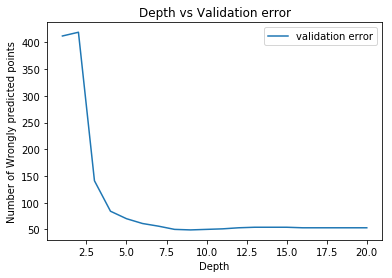

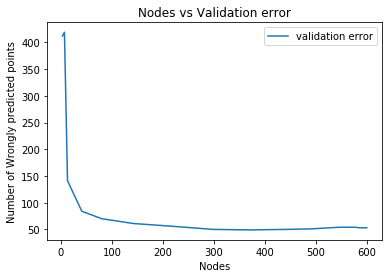

In [30]:
depth = [ x for x in range(1,21)]
f = open('depth_results_validation.txt','r')
nodes1 = []
valid_error = []
valid_total = 2248
actual_nodes = []
for x in f.readlines():
    if x != None :
        l = x.split(':')
        if "Total number of nodes" in l:
            nodes1.append(int(l[1]))
        if "Total wrong predicted" in l:
            valid_error.append((int(l[1])))
actual_nodes.append(3)
for i in range(1,len(nodes1)):
    actual_nodes.append(nodes1[i] - nodes1[i-1])

valid_error

plt.plot(depth, valid_error, label = "validation error") 
plt.xlabel("Depth")
plt.ylabel("Number of Wrongly predicted points")
plt.title("Depth vs Validation error")
plt.legend(loc='best')
plt.show()

plt.plot(actual_nodes, valid_error, label = "validation error") 
plt.xlabel("Nodes")
plt.ylabel("Number of Wrongly predicted points")
plt.legend(loc='best')
plt.title("Nodes vs Validation error")

plt.show()


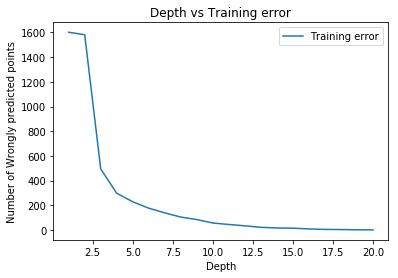

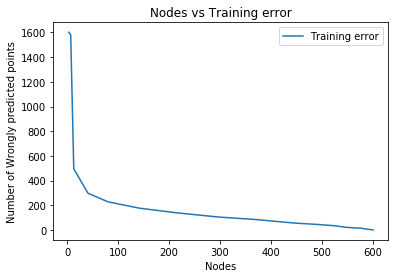

In [34]:

f = open('depth_results_train_data.txt','r')

valid_error = []

for x in f.readlines():
    if x != None :
        l = x.split(':')
        if "Total wrong predicted" in l:
            valid_error.append((int(l[1])))

plt.plot(depth, valid_error, label = "Training error") 
plt.xlabel("Depth")
plt.ylabel("Number of Wrongly predicted points")
plt.title("Depth vs Training error")
plt.legend(loc='best')
plt.show()

plt.plot(actual_nodes, valid_error, label = "Training error") 
plt.xlabel("Nodes")
plt.ylabel("Number of Wrongly predicted points")
plt.legend(loc='best')
plt.title("Nodes vs Training error")

plt.show()
